In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

### From google reviews:

In [2]:
# Load the dataset
df = pd.read_csv("CanadaPostGoogleReviews.csv")
df["Source"] = "Google reviews"
df = df[["Reviews", "Source"]]
df = df.dropna()
df.head(3)

,Reviews,Source
0,"Great customer service, never had an issue here. Barbara is super helpful and I'm always confident my packages will be dispatched efficiently here. Thank you!",Google reviews
1,The woman that works there in the afternoons is rude and has an attitude if you ask for a receipt. I wish they’d replace her,Google reviews
2,Great service fast and the staff alway polite. Barbara thank you for your professionalism.,Google reviews


In [3]:
def preprocess_text(text):
    if isinstance(text, str):
        
        text = text.lower() # Convert to lowercase       
        text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters and digits
        
    return text

In [4]:
# Applying preprocessing to the 'Reviews' column
df['Reviews'] = df['Reviews'].apply(preprocess_text)

In [5]:
# Sentiment analysis
sia = SentimentIntensityAnalyzer()
df['Sentiment'] = df['Reviews'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [6]:
# Applying TF-IDF vectorization
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(df['Reviews'])

In [7]:
# Performing topic modeling using LDA
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_matrix = lda_model.fit_transform(tfidf_matrix)

In [8]:
# Finding dominant topic for each review
dominant_topic = lda_matrix.argmax(axis=1)
df['Topic'] = dominant_topic

In [9]:
# Complaint analysis
negative_reviews = df[df['Sentiment'] < 0]
complaints = negative_reviews[['Reviews','Sentiment']]
complaints.sample(3)

,Reviews,Sentiment
670,unfriendly and unhelpful staff,-0.3612
310,avoid this location the two male staff are very rude and not helpful do better canada post,-0.8493
655,very disappointed rude and insufficient staffs obviously very unhappy with their job and no idea about customer care i read similar reviews below and im surprised that nobody has taken any action to fix this issue yet wow,-0.4704


In [10]:
# Customer service analysis
customer_service_reviews = df[df['Reviews'].str.contains('service', case=False)]

# User experience analysis
waiting_time_reviews = df[df['Reviews'].str.contains('wait', case=False)]
convenience_reviews = df[df['Reviews'].str.contains('convenient', case=False)]
damages_reviews = df[df['Reviews'].str.contains('damage', case=False)]

In [11]:
customer_service_reviews.sample(3)

,Reviews,Source,Sentiment,Topic
644,the service here is frankly terrible the staff are rude and show no interest in helping customers go to any other location if you can,Google reviews,-0.4767,0
1073,quick service and friendly service,Google reviews,0.4939,1
824,the filipino staffs there gave me attitude every time i ask any questions after my questions they looked at each other like what the heck this girl is asking before giving any explanation or answer if you are not willing to work in a customer service position you better not to be there,Google reviews,0.7783,1


In [12]:
waiting_time_reviews.sample(3)

,Reviews,Source,Sentiment,Topic
663,they closed half an hour earlier than they were supposed to while i was waiting at the door,Google reviews,0.0000,0
967,have come here to pick up and send off packages for the last years never had to wait more than minutes in line always treated in a professional manner have always been offered tracking and whatever addons to sending out packages but ive always declined with ease,Google reviews,0.5023,1
383,the reason why i order online less and less ive waited an hour to simply pick up a package countless times the audacity cp has in having one staff member at peak hours while the line snakes out the store is just amazing the height of incompetence,Google reviews,0.1280,1


In [13]:
convenience_reviews.sample(3)

,Reviews,Source,Sentiment,Topic
52,good experience overall the location is quite convenient too,Google reviews,0.4404,1
914,we have been going to this post office for a while now yeah its small but if you need to pick up a package send a money gram transfer or ship something they got you the hours staying open until pm makes it convenient when having to go after work the staff have been helpful and friendly,Google reviews,0.8625,1
623,this canada post location is located conveniently in the first canadian place i frequent this location often as its right by my workplace,Google reviews,0.0000,1


In [14]:
avg_overall_sent     = df['Sentiment'].mean()
avg_complaint_sent   = complaints['Sentiment'].mean()
avg_customer_sent    = customer_service_reviews['Sentiment'].mean()
avg_wait_sent        =  waiting_time_reviews['Sentiment'].mean()
avg_convenience_sent = convenience_reviews['Sentiment'].mean()
avg_damage_sent      = damages_reviews['Sentiment'].mean()

# Output
print(f"Overall Sentiment: { avg_overall_sent : .4f}")
print(f"Complaints: { avg_complaint_sent : .4f}")
print(f"Customer Service Reviews: { avg_customer_sent : .4f}")
print(f"Waiting Time Reviews: { avg_wait_sent : .4f}")
print(f"Convenience Reviews: { avg_convenience_sent : .4f}")
print(f"Damages Reviews: { avg_damage_sent : .4f}")

Overall Sentiment:  0.0410
Complaints: -0.5581
Customer Service Reviews: -0.0246
Waiting Time Reviews:  0.0498
Convenience Reviews:  0.4655
Damages Reviews:  nan


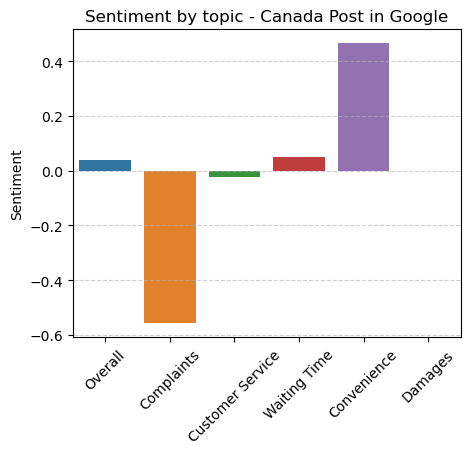

In [15]:
labels = ['Overall', 
          'Complaints', 
          'Customer Service',
          'Waiting Time',
          'Convenience',
          'Damages' 
         ]

data =  [avg_overall_sent, 
         avg_complaint_sent, 
         avg_customer_sent,
         avg_wait_sent,
         avg_convenience_sent,
         avg_damage_sent
         ]

plt.figure(figsize = (5, 4))

sns.barplot(x=labels, y=data)
plt.ylabel('Sentiment')
plt.title('Sentiment by topic - Canada Post in Google')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

In [16]:
percentage_positive_rev = df[df['Sentiment'] > 0].shape[0] / df.shape[0] * 100
percentage_neutral_rev = df[df['Sentiment'] == 0].shape[0] / df.shape[0] * 100
percentage_negative_rev = df[df['Sentiment'] < 0].shape[0] / df.shape[0] * 100

print(f"Percentage of positive reviews: {percentage_positive_rev : .2f}%")
print(f"Percentage of neutral reviews: {percentage_neutral_rev : .2f}%")
print(f"Percentage of negative reviews: {percentage_negative_rev : .2f}%")

Percentage of positive reviews:  45.72%
Percentage of neutral reviews:  9.74%
Percentage of negative reviews:  44.54%


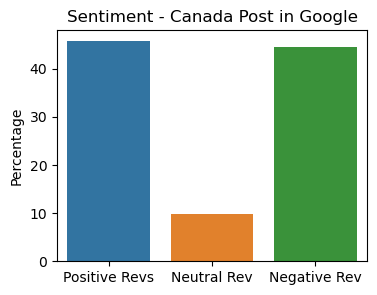

In [17]:
labels = ['Positive Revs', 'Neutral Rev', 'Negative Rev']

data = [percentage_positive_rev, 
        percentage_neutral_rev, 
        percentage_negative_rev]

plt.figure(figsize = (4, 3))

sns.barplot(x=labels, y=data)
plt.ylabel('Percentage')
plt.title('Sentiment - Canada Post in Google')
plt.show()

In [18]:
# Top 3 best reviews
df.sort_values(by = 'Sentiment', ascending = False).head(3)

,Reviews,Source,Sentiment,Topic
566,havent been to a post office in some time to buy stamps thought it would be slow at pm on a monday but i was pleasantly surprised a cheery staff person teresita greeted me and recommended that i buy the booklet of stamps with the cardinals on them the cardinal stamps are pretty cute,Google reviews,0.9765,0
580,its not often you get great service when theres a huge line at any business the male clerk with the buzzed hair and glasses was super friendly quick efficient and thorough i go to canada post often between three downtown locations and this was probably the best and most pleasant experience,Google reviews,0.9753,1
276,best canada post ive been to so far in the region service is excellent and most importantly staff is so nice helpful and always smiling this has became my postal office of choice i highly recommend going there for your postal services,Google reviews,0.9719,1


In [19]:
# Top 3 worst reviews
df.sort_values(by = 'Sentiment', ascending = False).tail(3)

,Reviews,Source,Sentiment,Topic
415,workers and customers here are angry miserable and they all look suicidal maybe cause the poor area avoid if you cankeep driving,Google reviews,-0.9460,0
303,rude staff the man in there was so rude and meanful person bad behavior and he threw my box on table and at the back he was saing bad words i didnt see like this before i was shocked,Google reviews,-0.9469,0
511,there is one man in particular who works here who is incredibly rude i was shocked to overhear him literally yell at a customer who wanted to check her po box just disgusting behaviour avoid this place if possible every time i have gone through this location this man is just a terror,Google reviews,-0.9549,1


In [20]:
df_google = df

### From Trustpilot:

In [21]:
# Load the dataset
df = pd.read_csv("reviews_trustpilot_Canada_Post_clean.csv")
df["Source"] = "Trustpilot"
df.rename(columns = {'0':'Reviews'}, inplace = True)
df = df.dropna()

df.sample(3)

,Reviews,Source
3164,If I could give 0 stars I would.\n\nThese clowns are the worst of the worst. Parcels late or in bad condition.\n\nJust placed an order over the weekend from Amazon and they chose Canada Post!! of course it never arrived on the guaranteed date and now apparently stuck/misplaced at the depot.\n\nClowns....typical government run crap service.,Trustpilot
1238,"I f i could gve a ZERO i would- paid $90 for express delivery to UK for a small package. got stopped along the way. been trying to find out what is the hold up. no one can tell me . their customer service center is useless- they cant ick u the phone and call someone to check this out? 3 weeks later - no sign of anything. they have the nerve to transfer me to the purolator office to figure it out myself? oh forgot to mention when i raised a service ticket , their system message said they would get back to me 3 months after i sent my package - 3 months!! (remember that i had sent the package rush for a 2 day delivery!!!??) . so when i called to check this out , they told me 2 weeks you would get some info. well its been 3 weeks and i am yet to receive anything. Typical governmental organization- no ownership of anything and its always someone else's fault",Trustpilot
3887,Canada Post has become a real pain in the .....! i paid to receive my order in 48h! MONDAY!!!!!!!! it's even written on their site that my order is due for today!!! STILL WAITING!!!!!!! 🤬🤬🤬🤬🤬🤬🤬🤬,Trustpilot


In [22]:
# Applying preprocessing to the 'Reviews' column
df['Reviews'] = df['Reviews'].apply(preprocess_text)

# Sentiment analysis
sia = SentimentIntensityAnalyzer()
df['Sentiment'] = df['Reviews'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Applying TF-IDF vectorization
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(df['Reviews'])

# Performing topic modeling using LDA
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_matrix = lda_model.fit_transform(tfidf_matrix)

# Finding dominant topic for each review
dominant_topic = lda_matrix.argmax(axis=1)
df['Topic'] = dominant_topic

df.sample(3)

,Reviews,Source,Sentiment,Topic
3189,i had some personal items mailed and paid extra to have them rushed it was supposed to take days before i knew it it had been weeks and my parcel had not arrived turns out they lost it after almost a month and a half they finally found my parcel and just mailed it back to the return address what a joke of a service now im afraid to mail anything in the fear they will lose it,Trustpilot,-0.7184,1
1476,a piece of sh service never be on time and always says slightly delay is or days delay slightly\nthey fool the customer hopefully it shut down soon completely,Trustpilot,-0.4471,1
3393,always delayed from what they say expected delivery whenever i see something being posted by canada post i get upset as they are never on time and usually not according to tracking information,Trustpilot,-0.5423,1


In [23]:
# Complaint analysis
negative_reviews = df[df['Sentiment'] < 0]
complaints = negative_reviews[['Reviews','Sentiment']]

complaints.sample(3)

,Reviews,Sentiment
1121,ordered rc parts express post yeah right no guarantee with covid forgot my unit number phoned cp undated it contacted cp today they said could take up to a week to get my lb package i can see the post office out my front window as i type this i work for a shipping company if i took a week to deliver a package less than a block id get fired companys get discounted rates when using one shipping company what your paying their are making off it when ever possible i avoid canada post is it owned by the government this would explain alot,-0.8984
1320,canada post is an embarrassment i ordered very expensive item they picked it up on feb nd and was supposed to reach me on feb th and guess what it is now march and they still have no info on where it is this is canada post for crying out loudso the sender opened a ticket on it and decided to send me the item by ups she had it picked up at pm on thursday february thfrom bellville ontario and it arrived february th at am near calgary alberta thats incredible but yet canada post has no idea what happened to my package bs also the item is pounds and xx not small at all so its not like it got misplacedthere answer from the manager was sorry there is nothing i can do this is very disgusting business practicecanada post is not reliable and in my opinion not worth using anymore,-0.9509
2454,last friday june th i ordered some lug nuts from miami florida and a cell phone case from montreal quebec\n\ni am near ottawa ontario lug nuts arrived from the states via fed ex this past wednesday june \n\nthe cell phone case to be delivered by canada post and a mere two hours away from my residence is still in transit,-0.5574


In [24]:
# Customer service analysis
customer_service_reviews = df[df['Reviews'].str.contains('service', case=False)]
customer_service_reviews.sample(3)

,Reviews,Source,Sentiment,Topic
3476,very bad delivery service\ni live in maple\nall time my packages and mail recieving for another persons becouse responsibility from canada post person put him to wrong mailbox,Trustpilot,-0.7841,1
1310,why do businesses continue to do business with cp is beyond me it has been the worst postal delivery service for decades package delivery take an iternity to arrive no accountability outclassed by all their competitors i patiently waited a week and a half for my package a new mobile phone being sent within my city not an international or provincial shipment check my tracking number verifying recipient address from the day tracking was availablea week ago ok i didnt get a call neither did my mobile company so i call oh yes sir your package is with us can you verify your address now now were clarifying two days later still no change to tracking info i call again oh yeah i see you spoke to someone im going to place a note it should ship next week utter garbage service and company,Trustpilot,-0.2111,1
508,wow i was forced to give one star to complete the review but they deserve zero canada post is masterful at dropping the ball many times i have noticed my tracking info has been doctored after an update has been made changing it to look like they are still on time i regularly place an order for items from a business in bc and am just blown away at the inconsistency of the delivery times to my home in sk they often love to sit on my orders when they arrive wed or thurs after a monday order only to have me wait until the following monday their virtual assistant is useless they have the nerve to post on their website they are working hard to stay safe blah blah news flash the rest of the world went back to normal service a year ago i would recommend if at all possible use another service,Trustpilot,0.9011,1


In [25]:
# User experience analysis
waiting_time_reviews = df[df['Reviews'].str.contains('wait', case=False)]
convenience_reviews = df[df['Reviews'].str.contains('convenient', case=False)]
damages_reviews = df[df['Reviews'].str.contains('damage', case=False)]

waiting_time_reviews.sample(3)

,Reviews,Source,Sentiment,Topic
309,from qc citymy parcel arrived and received by poste canada montreal on nov that i should get it by today is dec but i never got my product still waiting its the service too slow and troublesome,Trustpilot,-0.6652,1
2671,i have been waiting weeks for a package that came from europe at point of shipping it indicates that its in canada nowhas gone into the black hole called canada post this organization should be labelled a criminal organization for the prices they charge for the worlds worst postal service hey trudeau get your act together canada post hires the most incompetent management in the country,Trustpilot,-0.8977,1
2953,so today i was expecting a package i did not go to work today and i was waiting the whole day they said it would arrive by pm today and currently it is with no notice when i ordered the package on amazon it has said it shipped and is arriving today canada post workers are lazy there customer service is very very poor this will be the last time with this dog poo of a mail service pathetic,Trustpilot,-0.8852,1


In [26]:
convenience_reviews.sample(3)

,Reviews,Source,Sentiment,Topic
2851,i understand delays from covid but the fact that theyre focusing on new orders and letting old orders just sit there is completely obsurd ive been waiting for a month with no updates what i ordered loses freshness over time so this is very inconvenient,Trustpilot,-0.8515,1
1964,talk about convenient logged in created a label paid and printed drop off to my closest cp outlet compared to purolator who gave me inaccurate info on the phone so i wasted my entire lunch hour,Trustpilot,-0.6389,1
3780,when i lived in a condo i constantly had to travel kms to pick up my packages from their inconvenient pickup locations because their delivery person missed me they do not deliver to my apartment door and do not try to contact me on the intercom so i can come down and receive my package this meant that the literally only way to not miss me was if i literally waited in the lobby for the hour window they give for the deliveries if i wanted to pick up my purchases kms away i would not have ordered them online in contrast other services such as ups not only contacted me when they arrive for delivery but they even come up to my apartment directly to deliver the package\n\ntheir delivery times are also extremely slow and their delivery people from my experience generally do not care about the packages they are delivering i once ordered a rare large print from texas the delivery person literally damaged the package by forcefully stuffing it into the small mailbox in my building for mail instead of literally walking meters over and dropping off the package at the lobby front desk after contacting their customer support i was given a case number and told that the manager will speak with the delivery person so that it does not occur in the future they did not even offer to followup or to compensate for their incompetence absolutely ridiculous\n\nonly reason they are still in business is because they are a crown corporation,Trustpilot,-0.9233,1


In [27]:
damages_reviews.sample(3)

,Reviews,Source,Sentiment,Topic
1263,they damaged my package totally then i got nothing,Trustpilot,-0.4404,1
3113,i really dont like canada post i would recommend using any other postal shipping service that is available to you before canada post\n\nthere are a few reasons why i would say this but first id like to clarify that not all of my experiences with canada post are negative most of the people at the canada post locations are pleasant and helpful and i know of one mail carrier that is excellent\n\nhowever overall the service is unreliable their tracking information sucks and the canada post employees that arent good are very very bad\n\nwe used to live in a triplex and our front door was at the bottom of a small flight of stairs steps our mail carrier would throw any mail or parcels down those stairs and take off he disregarded our mailbox at the top of the steps he disregarded any damage that may be done to packages or the door on one occasion and if it was something we had to receive in person he would not even knock or leave a delivery notice we would have to find the tracking number and try to see if the package was ready for pickup and most of the time the counter person would complain that we didnt have the little delivery notice that he was supposed to leave\n\nwe brought the problem up with canada post a few times and eventually we had a new mail carrier we were happy that canada post took our problem seriously but as it turns out the new mail carrier was almost as lazy as the first one we no longer had flying mail and packages but they still wouldnt knock or leave delivery notices\n\nwe now live in a house in a rural community and we are still having some problems\n\nour mail carrier rarely comes down our\ndriveway to knock on our door to see if we are home instead they just automatically leave delivery notice in our mailbox and if they believe that they can cram the parcel in our mailbox they give that a tryi swear it sometimes looks like they stomped the box to get it in there\n\nanother problem we have is that any time it snows the mail carrier will refuse to deliver at all i have called to ask about it and the reason they gave me is that our mailbox and driveway are inaccessible and need to be cleared well thats a lie i always clear our driveway and mailbox and maintain it for the duration of the storm there is never an issue for any one else including my wife in her super low vw beetle who can drive right up to the mailbox to check if it contains any mail thats another thing they never raise the flag its just a convenient excuse that they use because they are lazy\n\nin general any package that i receive by canada post takes at least double the time of any other shipping company they also have useless tracking information\n\ni will receive a shipping confirmation and for a few days it will say item processed then maybe i get another item processed at my local canada post but most of the time it changes to out for delivery and it gives me an expected delivery date of the same day on average i have to wait another days before i actually receive the package or a delivery slip in my mailbox\n\nin the past i have tried to bypass the mail carrier and go directly to the post office when i see that the item has reached the local post office but they either dont want to help me at all or the package actually never got there yet i really dont understand how their tracking works\n\ni have switched to always using either fedex dhl or ups whenever possible they are always on time or ahead of schedule they also have the most friendly delivery people and tracking that is accurate,Trustpilot,-0.9850,1
3813,my parcel got damaged and it took them weeks to figure it out their customer service is a joke i have contacted them x regarding this parcel and have been given different information or directions every single time,Trustpilot,-0.1779,1


In [28]:
avg_overall_sent     = df['Sentiment'].mean()
avg_complaint_sent   = complaints['Sentiment'].mean()
avg_customer_sent    = customer_service_reviews['Sentiment'].mean()
avg_wait_sent        =  waiting_time_reviews['Sentiment'].mean()
avg_convenience_sent = convenience_reviews['Sentiment'].mean()
avg_damage_sent      = damages_reviews['Sentiment'].mean()

# Output
print(f"Overall Sentiment: { avg_overall_sent : .4f}")
print(f"Complaints: { avg_complaint_sent : .4f}")
print(f"Customer Service Reviews: { avg_customer_sent : .4f}")
print(f"Waiting Time Reviews: { avg_wait_sent : .4f}")
print(f"Convenience Reviews: { avg_convenience_sent : .4f}")
print(f"Damages Reviews: { avg_damage_sent : .4f}")

Overall Sentiment: -0.3621
Complaints: -0.6580
Customer Service Reviews: -0.4380
Waiting Time Reviews: -0.3750
Convenience Reviews: -0.4293
Damages Reviews: -0.6213


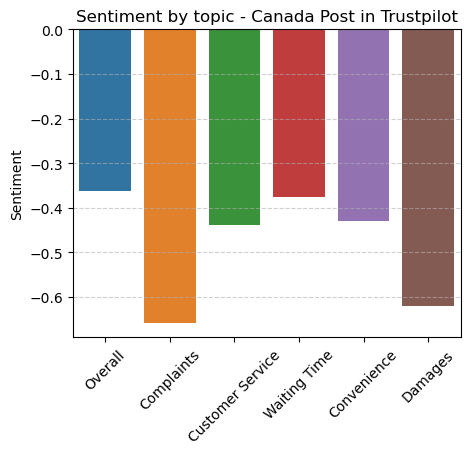

In [29]:
labels = ['Overall', 
          'Complaints', 
          'Customer Service',
          'Waiting Time',
          'Convenience',
          'Damages' 
         ]

data =  [avg_overall_sent, 
         avg_complaint_sent, 
         avg_customer_sent,
         avg_wait_sent,
         avg_convenience_sent,
         avg_damage_sent
         ]

plt.figure(figsize = (5, 4))

sns.barplot(x=labels, y=data)
plt.ylabel('Sentiment')
plt.title('Sentiment by topic - Canada Post in Trustpilot')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

In [30]:
percentage_positive_rev = df[df['Sentiment'] > 0].shape[0] / df.shape[0] * 100
percentage_neutral_rev = df[df['Sentiment'] == 0].shape[0] / df.shape[0] * 100
percentage_negative_rev = df[df['Sentiment'] < 0].shape[0] / df.shape[0] * 100

print(f"Percentage of positive reviews: {percentage_positive_rev : .2f}%")
print(f"Percentage of neutral reviews: {percentage_neutral_rev : .2f}%")
print(f"Percentage of negative reviews: {percentage_negative_rev : .2f}%")

Percentage of positive reviews:  23.29%
Percentage of neutral reviews:  4.31%
Percentage of negative reviews:  72.40%


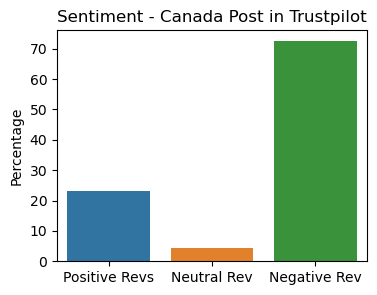

In [31]:
labels = ['Positive Revs', 'Neutral Rev', 'Negative Rev']

data = [percentage_positive_rev, 
        percentage_neutral_rev, 
        percentage_negative_rev]

plt.figure(figsize = (4, 3))

sns.barplot(x=labels, y=data)
plt.ylabel('Percentage')
plt.title('Sentiment - Canada Post in Trustpilot')
plt.show()

In [32]:
# Top 3 best reviews
df.sort_values(by = 'Sentiment', ascending = False).head(3)

Reviews  \
4128  their chat online system is a joke i wonder if other people had the same experience as me read the convo below keep in mind i waited patiently to get my answer also i gave my actual info but had to keep this confidential\n\n\nin response to question hi  i am just wondering if you know where my package is currently located here is my number tracking number\nit looks like it is in british columbia i just want to confirm\nthanks\nana\n\na\nhi  i am just wondering if you know where my package is currently located here is my number tracking number\nit looks like it is in british columbia i just want to confirm\nthanks\nana\nsystem hi ana thank you for visiting\nkeep in mind this conversation will end if left inactive for  minutes\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\na\nok i am still active\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\na\nok i am still active \nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\na\nok i am still active\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\na\nok still active \nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to chat with an agent customers are ahead of you\nsystem youre in line to ch

In [33]:
# Top 3 worst reviews
df.sort_values(by = 'Sentiment', ascending = False).tail(3)

,Reviews,Source,Sentiment,Topic
1313,brutal\ndont speak with customer service its a waste of time they cant answer any questions or get any more details on your parcel than the automated service can give you and that is no info\nthe post offices arent scanning items properly so u never know when ur getting your things all my parcels are insanly late and its sitting min away from me but i cant pick it up this service is the worst ive experienced the absolute worst\nif you can avoid using them for your mail then ur better off\nwhen the people cant even call the office your stuff is sitting at then thats lower than low\ncanada post are thieves stealing money with false promis of delivering on time or close to ontime\n\nlies lies lies\n\nterrible terrible service not even star guys of a star\n\nvery poor very very poor services,Trustpilot,-0.9961,1
2309,every package that has been handed over to canada post has either been lost or delayed for months with no tracking information why is it that every other courier service has gotten their acts together and are able to get packages out on a timely manner but everyone thats been handed over to canada post is either lost delayed for months and you cant find any information on them whatsoever what the hell is going on with canada post they have failed miserably servicing their customers through covid where every other business has gotten their acts together through this pandemic and are giving their customers good service no excuse i am really sick of my packages being lost or delayed for months with no tracking information availableand trying to speak to somebody or even post a complaint online on their web page is absolutely ridiculous canada post get your damn acts together and stop using the pandemic as an excuse for your s service no other courier service is having delays like you are its absolutely asinine when things are sitting in mississauga or kitchener for weeks on end get it together man people pay for service and you are not delivering your service you cant even get a hold of you to complain its b and its unacceptable get it together and stop using whats happening in the world as an excuse no other company that delivers parcels or mail are giving a horrible service like canada post you people are an absolute rip off ridiculous organization and i have to laugh because it seems amazon is no longer handing their parcels over to you as youve lost every one of my parcels from amazon that have been handed to you and im happy to say none of my parcels from amazon have been delivered by canada post anymore theyre using different courier services or theyre delivering the parcels themselves once again why are you the only ones failing in this industry miserably failing i might add get it together man,Trustpilot,-0.9962,1
3706,horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible horrible gahhhhhhhhhhhhhhhh,Trustpilot,-0.9998,1


In [34]:
df_trustpilot = df

### From Reddit:

In [35]:
# Load the dataset
df = pd.read_csv("reviews_reddit_Canada_Post.csv")
df = df.rename(columns = {'Sender: Unavailable':'Reviews'})
df["Source"] = "Reddit"
df = df.dropna()
df.head(3)

,Reviews,Source
0,I had two parcels that had arrived in Mississauga customs on April 10th. They were just released this morning and scanned with Canada Post Mississauga. 26 days in customs in case anyone is wondering.,Reddit
1,Waiting for my package to be delivered - it says item accepted at post office @ Toronto on May 25th 7:31pm,Reddit
2,Odds of lettermail showing up after a month?,Reddit


In [36]:
# Applying preprocessing to the 'Reviews' column
df['Reviews'] = df['Reviews'].apply(preprocess_text)

# Sentiment analysis
sia = SentimentIntensityAnalyzer()
df['Sentiment'] = df['Reviews'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Applying TF-IDF vectorization
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(df['Reviews'])

# Performing topic modeling using LDA
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_matrix = lda_model.fit_transform(tfidf_matrix)

# Finding dominant topic for each review
dominant_topic = lda_matrix.argmax(axis=1)
df['Topic'] = dominant_topic

df.sample(3)

,Reviews,Source,Sentiment,Topic
185,probably the last update for now,Reddit,0.0000,1
825,taped up mailboxes,Reddit,0.0000,1
926,conspiracy theory in mail,Reddit,-0.5267,2


In [37]:
# Complaint analysis
negative_reviews = df[df['Sentiment'] < 0]
complaints = negative_reviews[['Reviews','Sentiment']]
complaints.sample(3)

,Reviews,Sentiment
56,i am starting to hate canada post,-0.5719
568,package stolen from post office,-0.4939
701,stuck in richmond since the th sal in transit for days what do i do,-0.2500


In [38]:
# Customer service analysis
customer_service_reviews = df[df['Reviews'].str.contains('service', case=False)]

# User experience analysis
waiting_time_reviews = df[df['Reviews'].str.contains('wait', case=False)]
convenience_reviews = df[df['Reviews'].str.contains('convenient', case=False)]
damages_reviews = df[df['Reviews'].str.contains('damage', case=False)]

In [39]:
customer_service_reviews.sample(3)

,Reviews,Source,Sentiment,Topic
830,got a text this morning saying package was out for delivery then i saw that error ive called cp customer service and filed a ticket whats the odds my package could be returned back to sender,Reddit,-0.4019,0
939,hold mail service,Reddit,0.0000,0
429,package stuck on item has been presented to canada border services agency for customs review since april th,Reddit,-0.2500,1


In [40]:
waiting_time_reviews.sample(3)

,Reviews,Source,Sentiment,Topic
744,how long does mail wait in the mailbox,Reddit,0.0000,2
709,this was canada posts response to my lost amazon return again although i mentioned this to amazon they have just told me its not processed and that i must wait until febuary been almost three weeks,Reddit,0.0258,2
894,delayed waiting for updates,Reddit,-0.2263,2


In [41]:
convenience_reviews.sample()

,Reviews,Source,Sentiment,Topic
179,canada post is literally the most inconvenient courier in the world,Reddit,-0.4005,0


In [42]:
damages_reviews.sample(3)

,Reviews,Source,Sentiment,Topic
150,damaged package influx,Reddit,-0.4404,2
672,had an insured item that was damaged in delivery canada post saying they cant contact buyer so they cant proceed with refund,Reddit,-0.4404,2
891,how to handle a previous owners letter thats been severely damaged at reception,Reddit,-0.7096,1


In [43]:
avg_overall_sent     = df['Sentiment'].mean()
avg_complaint_sent   = complaints['Sentiment'].mean()
avg_customer_sent    = customer_service_reviews['Sentiment'].mean()
avg_wait_sent        =  waiting_time_reviews['Sentiment'].mean()
avg_convenience_sent = convenience_reviews['Sentiment'].mean()
avg_damage_sent      = damages_reviews['Sentiment'].mean()

# Output
print(f"Overall Sentiment: { avg_overall_sent : .4f}")
print(f"Complaints: { avg_complaint_sent : .4f}")
print(f"Customer Service Reviews: { avg_customer_sent : .4f}")
print(f"Waiting Time Reviews: { avg_wait_sent : .4f}")
print(f"Convenience Reviews: { avg_convenience_sent : .4f}")
print(f"Damages Reviews: { avg_damage_sent : .4f}")

Overall Sentiment: -0.0598
Complaints: -0.3638
Customer Service Reviews: -0.1255
Waiting Time Reviews:  0.0243
Convenience Reviews: -0.4005
Damages Reviews: -0.5301


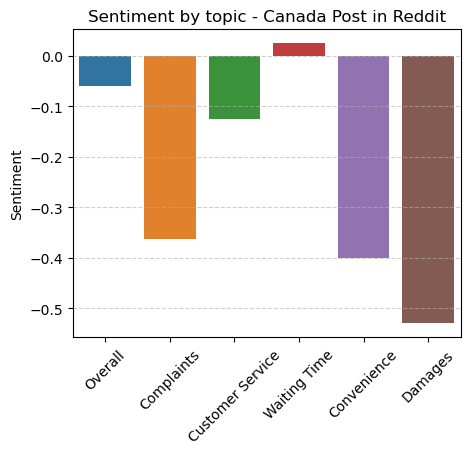

In [44]:
labels = ['Overall', 
          'Complaints', 
          'Customer Service',
          'Waiting Time',
          'Convenience',
          'Damages' 
         ]

data =  [avg_overall_sent, 
         avg_complaint_sent, 
         avg_customer_sent,
         avg_wait_sent,
         avg_convenience_sent,
         avg_damage_sent
         ]

plt.figure(figsize = (5, 4))

sns.barplot(x=labels, y=data)
plt.ylabel('Sentiment')
plt.title('Sentiment by topic - Canada Post in Reddit')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

In [45]:
percentage_positive_rev = df[df['Sentiment'] > 0].shape[0] / df.shape[0] * 100
percentage_neutral_rev = df[df['Sentiment'] == 0].shape[0] / df.shape[0] * 100
percentage_negative_rev = df[df['Sentiment'] < 0].shape[0] / df.shape[0] * 100

print(f"Percentage of positive reviews: {percentage_positive_rev : .2f}%")
print(f"Percentage of neutral reviews: {percentage_neutral_rev : .2f}%")
print(f"Percentage of negative reviews: {percentage_negative_rev : .2f}%")

Percentage of positive reviews:  16.53%
Percentage of neutral reviews:  52.02%
Percentage of negative reviews:  31.45%


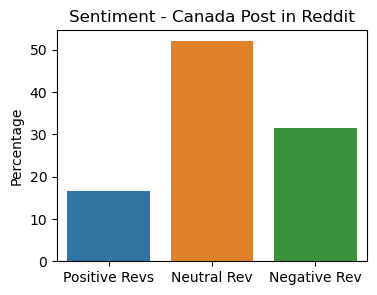

In [46]:
labels = ['Positive Revs', 'Neutral Rev', 'Negative Rev']

data = [percentage_positive_rev, 
        percentage_neutral_rev, 
        percentage_negative_rev]

plt.figure(figsize = (4, 3))

sns.barplot(x=labels, y=data)
plt.ylabel('Percentage')
plt.title('Sentiment - Canada Post in Reddit')
plt.show()

In [47]:
# Top 3 best reviews
df.sort_values(by = 'Sentiment', ascending = False).head(3)

,Reviews,Source,Sentiment,Topic
664,cheer me up with your best late package story mine has been missing weeks and i want to believe there is hope it may still show up,Reddit,0.8591,0
480,what steps can i take to confirm my address and make sure i can pickup or receive my parcel it is very time sensitive im positive it was shipped to the correct address never had this happen before thank you,Reddit,0.8126,2
151,what the heck this is the second day a row they do this weather is perfectly clear out here non sense,Reddit,0.7783,1


In [48]:
# Top 3 worst reviews
df.sort_values(by = 'Sentiment', ascending = False).tail(3)

,Reviews,Source,Sentiment,Topic
79,so why the hell arent we allowed to pay duties and taxes online anymore,Reddit,-0.7402,2
208,whats the point of having a delivery standard if it is never followed how is it called a standard when it never fucking happens express post is supposed to take days it always takes a fucking week ridiculous bullshit,Reddit,-0.7809,0
372,been recieving these sometimes im expecting some canada post pkgs but i dont know if this is a scam or a legitimate attempt to contact gut tells me scam,Reddit,-0.9022,2


In [49]:
df_reddit = df

In [50]:
df = pd.concat([df_google, df_trustpilot, df_reddit], ignore_index = True)

In [51]:
df.to_csv('Canada Post consolidated.csv', index = False)